Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
# Print the number of tran and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15740 files belonging to 9 classes.
Using 12592 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 15740 files belonging to 9 classes.
Using 3148 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
print(train_ds)
print(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

1 seborrheic keratosis
2 basal cell carcinoma
3 pigmented benign keratosis
4 nevus
5 actinic keratosis
6 squamous cell carcinoma
7 melanoma
8 dermatofibroma
9 vascular lesion


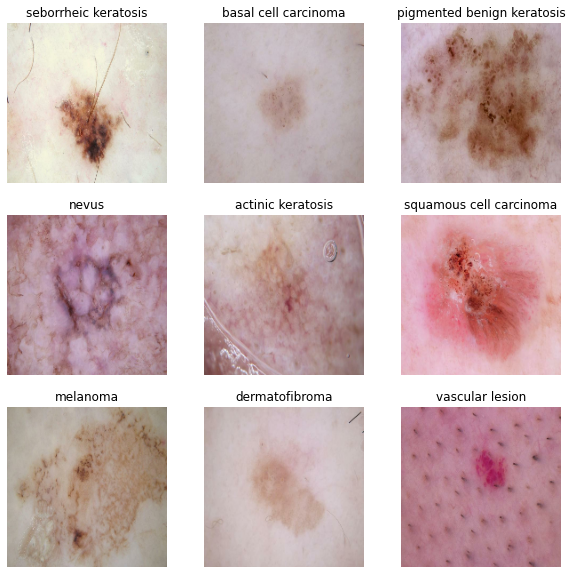

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
class_seen = []
image_count = 0
for images, labels in train_ds.take(5):
    for i in range(32):
        if class_names[labels[i]] not in class_seen:
            print(image_count+1, class_names[labels[i]])
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            class_seen.append(class_names[labels[i]])
            image_count += 1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Rescale the image
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

99/99 [==============================] - 1s 14ms/step - loss: 0.3466 - accuracy: 0.8987
Accuracy:  0.9609275460243225
Validation Accuracy:  0.8986658453941345
Loss:  0.10397648811340332
Validation Loss 0.34659215807914734


### Visualizing training results

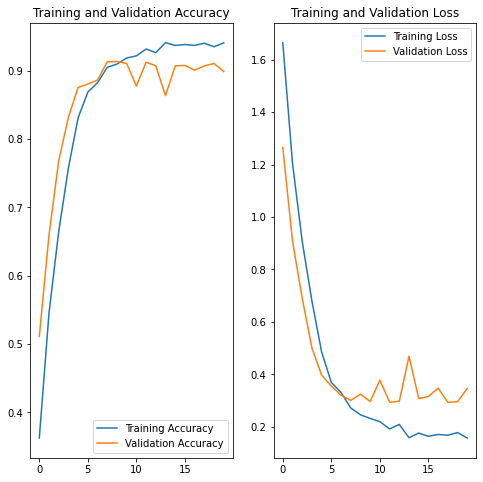

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Initial findings

*   In 20 epochs, we can observe that accuracy for <br>
 training  : 96.07% <br>
 validation : 89.86%. <br> 
 In terms of training and validation loss, we can observe training loss continuous decreases where as validation loss decreases upto 7 epochs. 
*   **Model is overfitting**, as its calculated w.r.t. loss, and we can see the difference between loss in training and validation around 19-20th epoch; At the same we can notice training and validation accuracy



In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
from keras.preprocessing.image import ImageDataGenerator

data_aug = keras.Sequential([
       layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
       layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
       layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

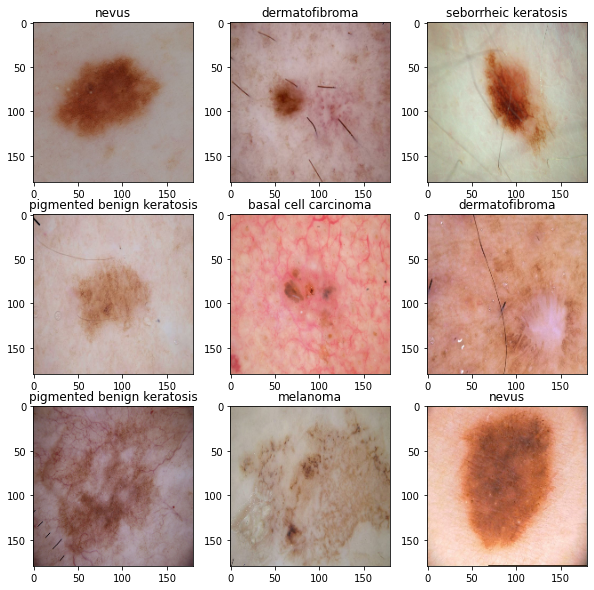

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in  train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (180,180,3)
num_classes = 9

model = Sequential([ data_aug,
   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [ ]:
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 14s 43ms/step - loss: 1.7659 - accuracy: 0.3183 - val_loss: 1.5505 - val_accuracy: 0.3741
Epoch 2/30
281/281 [==============================] - 12s 42ms/step - loss: 1.5089 - accuracy: 0.4121 - val_loss: 1.4666 - val_accuracy: 0.4199
Epoch 3/30
281/281 [==============================] - 12s 42ms/step - loss: 1.4161 - accuracy: 0.4438 - val_loss: 1.3427 - val_accuracy: 0.4684
Epoch 4/30
281/281 [==============================] - 12s 42ms/step - loss: 1.3481 - accuracy: 0.4669 - val_loss: 1.4097 - val_accuracy: 0.4729
Epoch 5/30
281/281 [==============================] - 12s 42ms/step - loss: 1.3146 - accuracy: 0.4870 - val_loss: 1.2888 - val_accuracy: 0.4875
Epoch 6/30
281/281 [==============================] - 12s 42ms/step - loss: 1.2557 - accuracy: 0.5040 - val_loss: 1.2214 - val_accuracy: 0.5289
Epoch 7/30
281/281 [==============================] - 12s 42ms/step - loss: 1.2267 - accuracy: 0.5181 - val_loss: 1.2165 - val_accuracy: 0.5196
Epo

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


71/71 [==============================] - 1s 14ms/step - loss: 0.8727 - accuracy: 0.6940
Accuracy:  0.7266458868980408
Validation Accuracy:  0.6939501762390137
Loss:  0.7439374327659607
Validation Loss 0.8727138638496399


### Visualizing the results

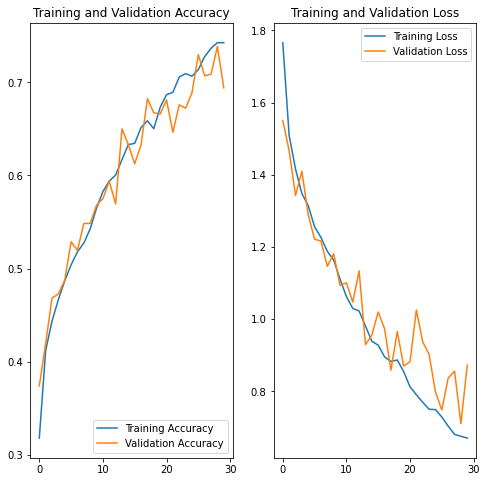

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings

*  With data augmentation strategy, we can see that training and validation accuracy fairly aligns and remain constant, where training and validation loss constantly decreases over period of time.

*  Though model accuracy has gone down, but model is not overfitting and requires more hyper parameter tuning. one of the option could be to train for more number of epocs and see the accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

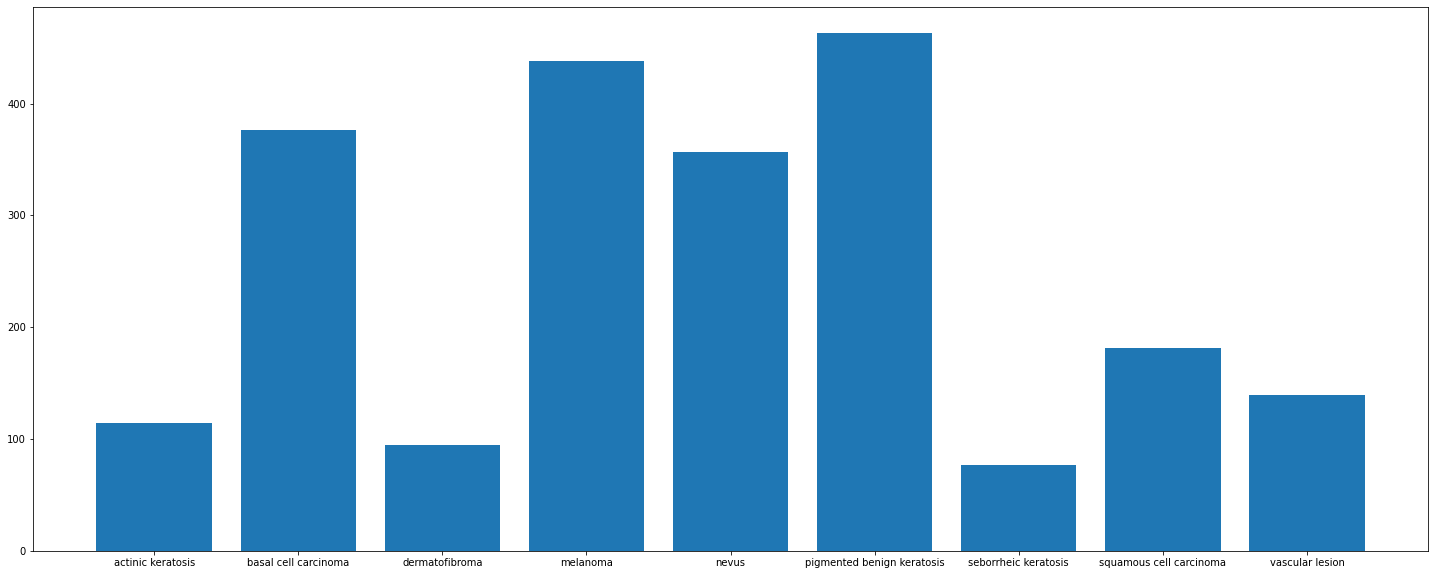

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans: "seborrheic keratosis" has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: "pigmented benign keratosis" has the more number of samples compared to other classes.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
  path_to_training_dataset="/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C4F0CDFD0>: 100%|██████████| 500/500 [00:19<00:00, 26.04 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7C4C12DA90>: 100%|██████████| 500/500 [00:20<00:00, 24.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C4C1A41D0>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7C4C15E410>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F7C4C1BAC10>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 463 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D788B0C50>: 100%|██████████| 500/500 [00:19<00:00, 25.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7C4F4102D0>: 100%|██████████| 500/500 [00:42<00:00, 11.80 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C4F84C410>: 100%|██████████| 500/500 [00:17<00:00, 27.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7C4F12DF10>: 100%|██████████| 500/500 [00:17<00:00, 28.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_0723ba0c-d2d6-42ed-bc87-81f80c4a3e69.jpg',
 '/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_cad8ff89-f954-48c7-8378-15425af4a5ba.jpg',
 '/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_cab65ca9-50ae-4c7b-9901-c0c8bc52276d.jpg',
 '/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_bfb43a9d-9862-4f54-82fa-97c46c75b3bf.jpg',
 '/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collabo

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
##new_df = original_df.append(df2)
new_df =df2

In [ ]:
new_df['Label'].value_counts()

actinic keratosis             1500
dermatofibroma                1500
basal cell carcinoma          1500
melanoma                      1500
pigmented benign keratosis    1500
nevus                         1500
seborrheic keratosis          1500
squamous cell carcinoma       1500
vascular lesion               1500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/My Drive/Assignment/cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15740 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15740 files belonging to 9 classes.
Using 3148 files for validation.


In [ ]:
print(train_ds)
print(val_ds)


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [ ]:
epochs = 30 
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


394/394 [==============================] - 78s 193ms/step - loss: 1.7582 - accuracy: 0.3259 - val_loss: 1.3630 - val_accuracy: 0.4876
Epoch 2/30
394/394 [==============================] - 64s 161ms/step - loss: 1.3356 - accuracy: 0.4859 - val_loss: 1.0724 - val_accuracy: 0.5937
Epoch 3/30
394/394 [==============================] - 62s 155ms/step - loss: 1.0184 - accuracy: 0.6229 - val_loss: 0.7961 - val_accuracy: 0.6941
Epoch 4/30
394/394 [==============================] - 62s 154ms/step - loss: 0.7144 - accuracy: 0.7405 - val_loss: 0.5524 - val_accuracy: 0.8005
Epoch 5/30
394/394 [==============================] - 62s 155ms/step - loss: 0.5307 - accuracy: 0.8151 - val_loss: 0.4435 - val_accuracy: 0.8545
Epoch 6/30
394/394 [==============================] - 62s 155ms/step - loss: 0.4044 - accuracy: 0.8584 - val_loss: 0.4441 - val_accuracy: 0.8488
Epoch 7/30
394/394 [==============================] - 68s 169ms/step - loss: 0.3161 - accuracy: 0.8879 - val_loss: 0.3545 - val_accuracy: 0.8

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


99/99 [==============================] - 12s 110ms/step - loss: 0.4483 - accuracy: 0.8914
Accuracy:  0.9624364972114563
Validation Accuracy:  0.8913595676422119
Loss:  0.09917635470628738
Validation Loss 0.44829070568084717


#### **Todo:**  Visualize the model results

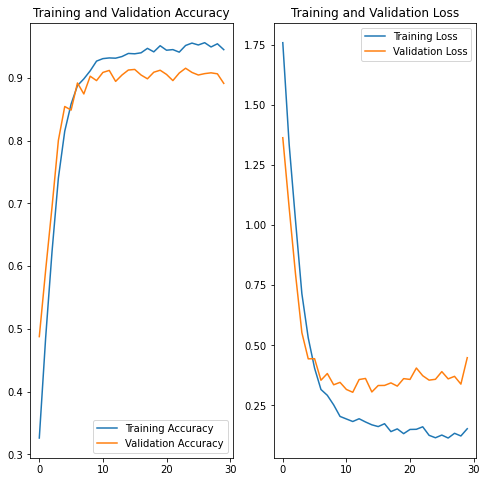

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



With class imbalance and generating some sample images, we can see that training and validation accuracy has gone up. Training accuracy has increased upto > 90% and validation accuracy is around 89%.

With more hyper parameter tunining, accuracy can be increased further.

Final summary
At first, model was overfitting with basic sample images where training accuracy was approx 96% and validation accuracy was 89%

With basic tuning and help of Augumentation we were able to train the sample further and model seems to perform better where training and validation accuracy both were close to 90%, tranining loss and validation loss is sync which indicates there is no overfitting.